In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import scanpy as sc
import sctop as top

In [14]:
sns.set(context='talk', color_codes=True, palette='deep', style='whitegrid',
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':400, 'text.usetex':False}) #font_scale=0.3,

In [2]:
data_folder = '/projectnb/biophys/mariay/Batch effect pancreatic data/'
pancreatic_data = pd.read_csv(data_folder + 'myData_pancreatic_5batches.txt.gz', sep='\t')
pancreatic_metadata = pd.read_csv(data_folder + 'mySample_pancreatic_5batches.txt.gz', sep='\t')

In [3]:
pancreatic_metadata['celltype'].value_counts()

alpha           5100
beta            3826
ductal          1804
acinar          1368
delta            966
gamma            656
stellate         511
endothelial      289
mesenchymal      107
macrophage        55
mast              32
epsilon           28
schwann           13
t_cell             7
MHC class II       5
Name: celltype, dtype: int64

In [34]:
baron_metadata = pancreatic_metadata.loc[pancreatic_metadata['batchlb'] == 'Baron_b1']
type_counts = baron_metadata['celltype'].value_counts()
threshold = 200 # only use cell types with at least this many cells
types_above_threshold = type_counts[type_counts > threshold].index

basis_list = []
training_IDs = []

rng = np.random.default_rng()

for cell_type in types_above_threshold:
    cell_IDs = baron_metadata[baron_metadata['celltype'] == cell_type].index
    current_IDs = cell_IDs
    cell_counts = pancreatic_data[current_IDs]
    training_IDs += [current_IDs]
    
    processed = top.process(cell_counts, average=True)
    basis_list += [processed]
    
training_IDs = np.concatenate(training_IDs)
basis = pd.concat(basis_list, axis=1)
basis.columns = types_above_threshold

In [35]:
test_IDs = np.setdiff1d(pancreatic_data.columns, training_IDs)
test_data = pancreatic_data[test_IDs]
test_processed = top.process(test_data)
test_projections = top.score(basis, test_processed)

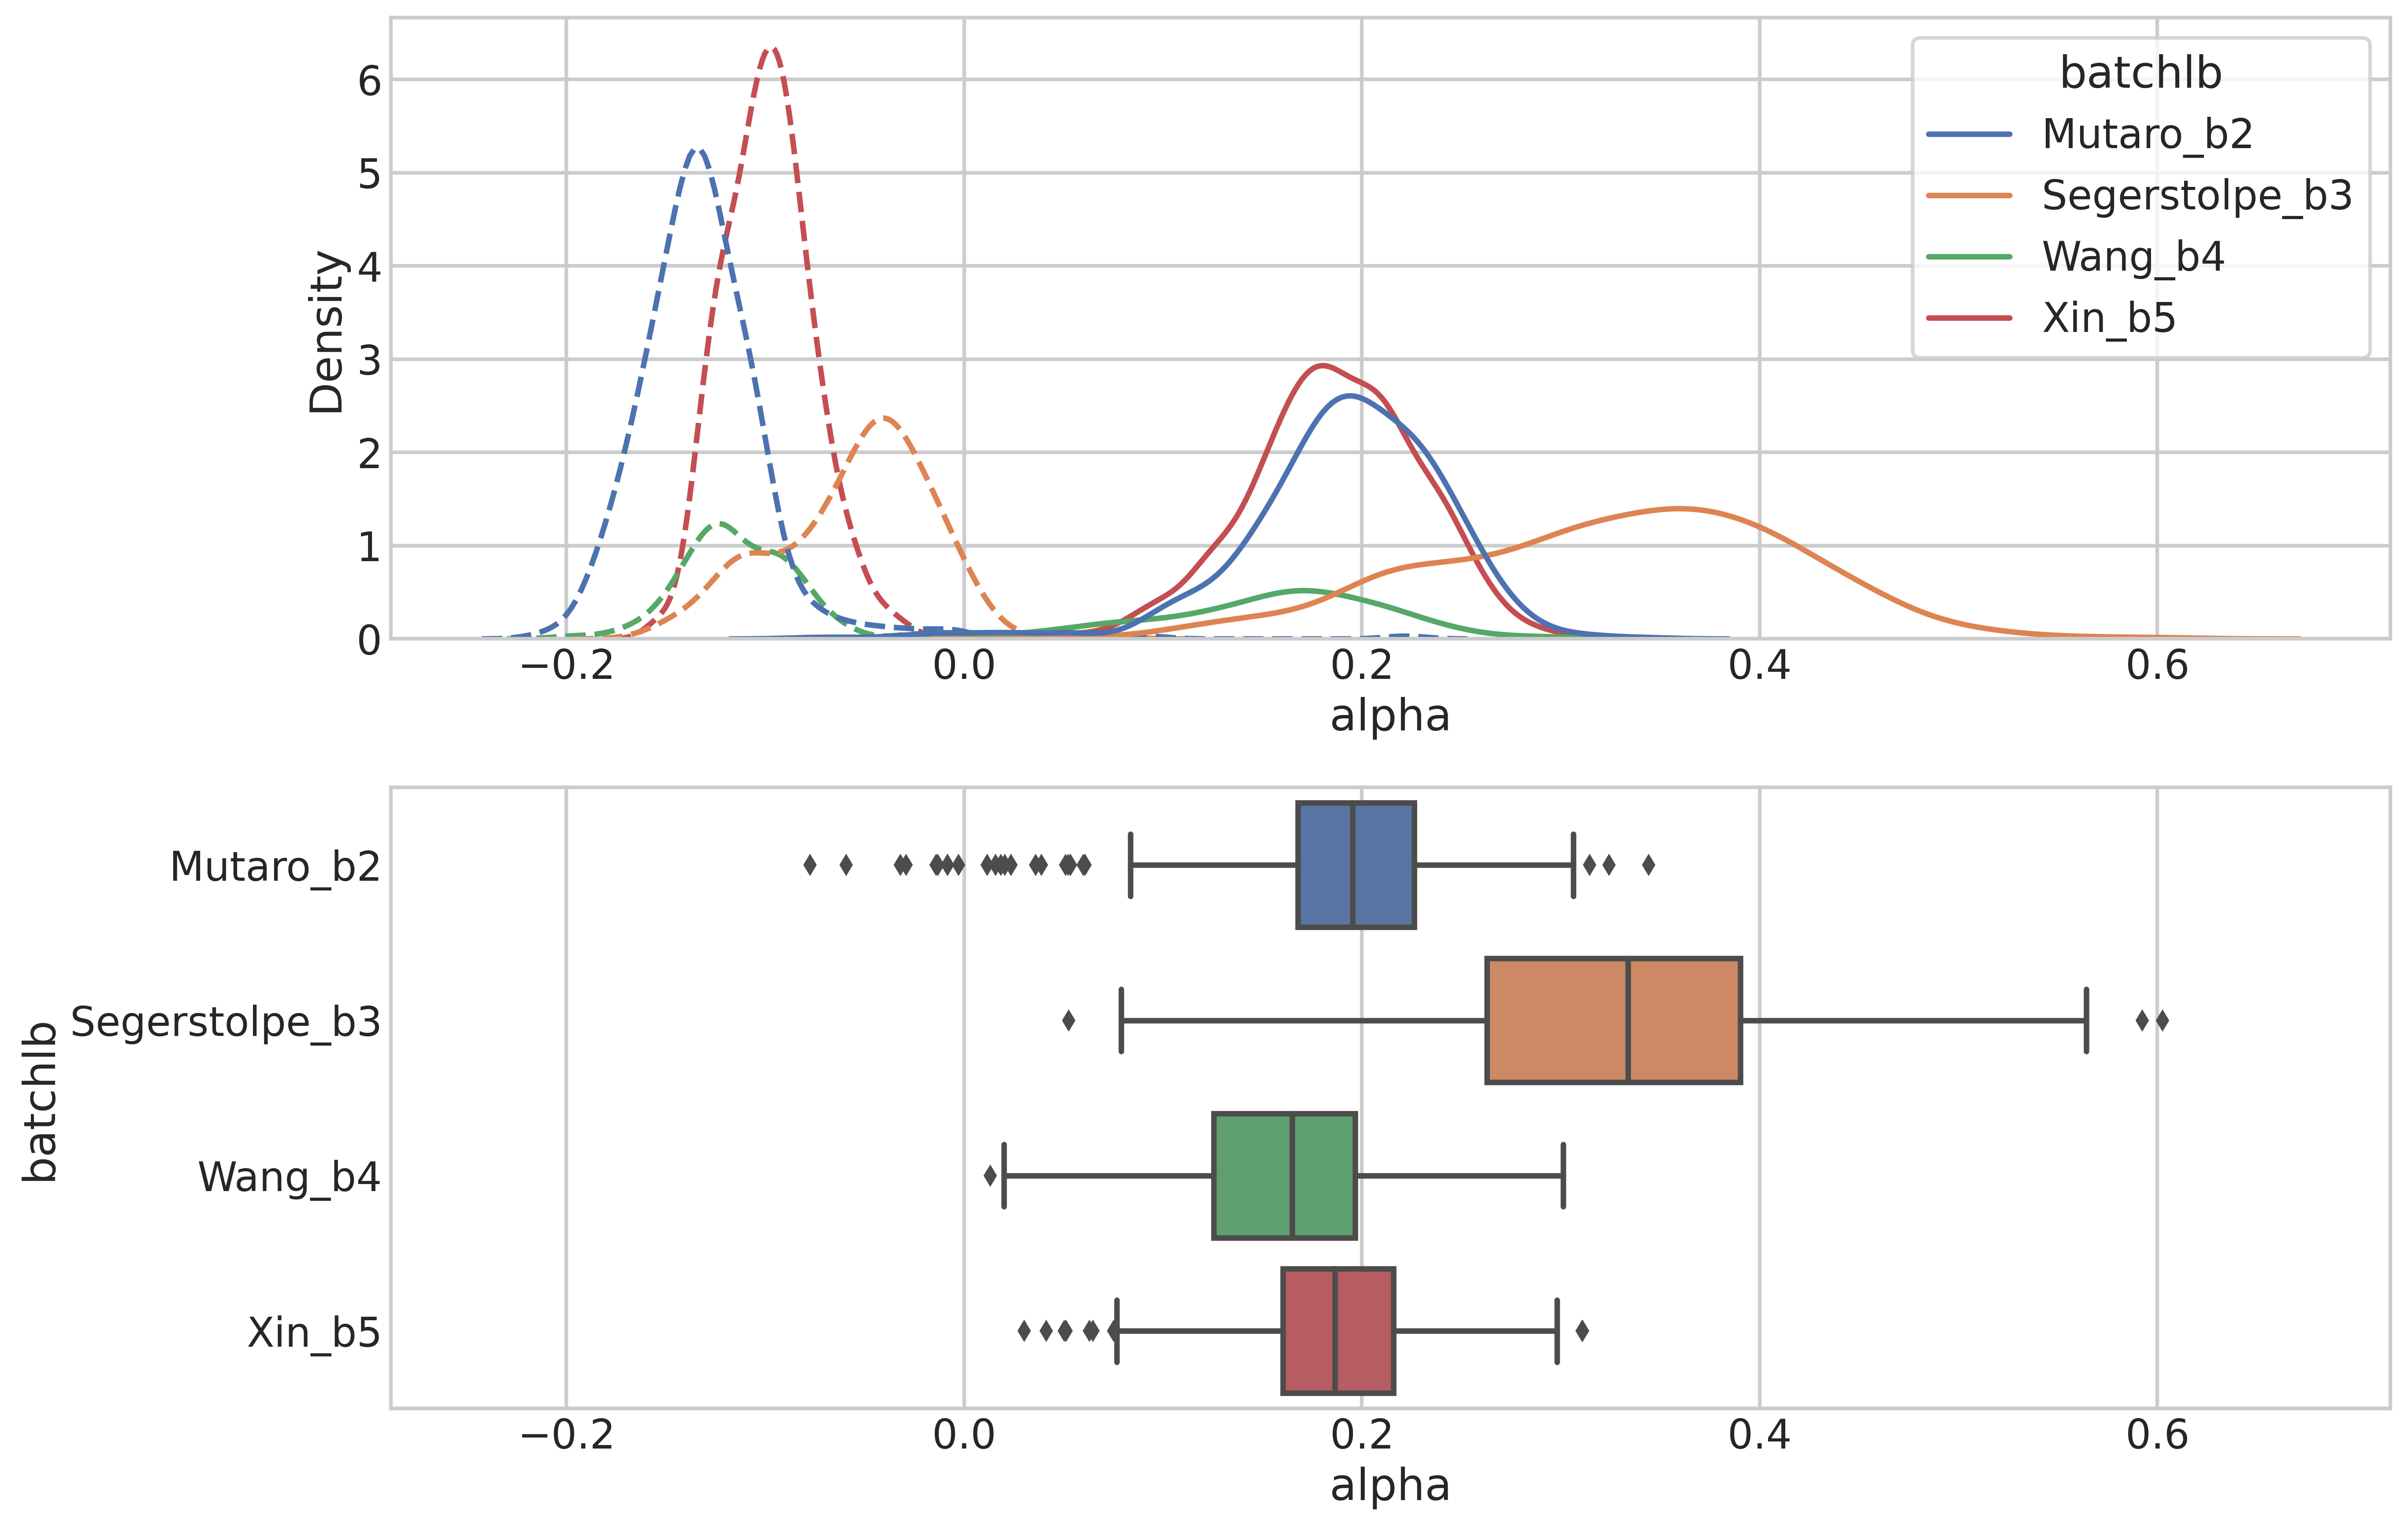

In [44]:
# Let's look at distributions
sample_type = 'beta'
reference_type = 'alpha'

test_metadata = pancreatic_metadata.loc[test_IDs]
current_IDs = test_metadata[test_metadata['celltype'] == sample_type].index

current_projections = test_projections[current_IDs].loc[reference_type]
projections_and_sources = pd.concat([current_projections, test_metadata.loc[current_IDs]['batchlb']], axis=1)
batch_order = pancreatic_metadata['batchlb'].unique()[1:]

fig, axes = plt.subplots(2, 1, figsize=(14, 9))

sns.kdeplot(data = projections_and_sources,
            x = reference_type,
            hue='batchlb', 
            hue_order=batch_order,
            ax = axes[0],
            linestyle='--'
           )

test_metadata = pancreatic_metadata.loc[test_IDs]
current_IDs = test_metadata[test_metadata['celltype'] == 'alpha'].index

current_projections = test_projections[current_IDs].loc[reference_type]
projections_and_sources = pd.concat([current_projections, test_metadata.loc[current_IDs]['batchlb']], axis=1)


sns.kdeplot(data = projections_and_sources,
            x = reference_type,
            hue='batchlb', 
            hue_order=batch_order,
            ax = axes[0],
           )

sns.boxplot(data=projections_and_sources,
            x=reference_type,
            y='batchlb',
            order = batch_order,
            ax = axes[1]
           )

axes[1].set_xlim(axes[0].get_xlim())

plt.tight_layout()
plt.savefig("./alpha (beta) scores.pdf", transparent=True, bbox_inches = "tight")
plt.show()